Please see [the first chapter where getting the data and processing RNA modality are described](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.ipynb) and [the second chapter with ATAC modality processing](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.ipynb)


This is the third chapter of the multimodal single-cell gene expression and chromatin accessibility analysis. In this notebook, we will see how to learn a latent space jointly on two omics.

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../../")

# Load libraries and data

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import muon as mu

Load the MuData object from the `.h5mu` file:

In [4]:
mdata = mu.read("data/pbmc10k.h5mu")
mdata

MuData object with n_obs × n_vars = 11165 × 132440
  var:	'dispersions', 'dispersions_norm', 'feature_types', 'gene_ids', 'genome', 'highly_variable', 'interval', 'mean', 'means', 'n_cells', 'std'
  2 modalities
    atac:	9816 x 106084
      obs:	'n_genes', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	10886 x 26346
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', '

In each modality, only cells passing respective QC are retained. For the multimodal data integration, we will use only cells that are present for both modalities:

In [5]:
mu.pp.intersect_obs(mdata)

In [6]:
mdata

MuData object with n_obs × n_vars = 9537 × 132440
  var:	'dispersions', 'dispersions_norm', 'feature_types', 'gene_ids', 'genome', 'highly_variable', 'interval', 'mean', 'means', 'n_cells', 'std'
  2 modalities
    atac:	9537 x 106084
      obs:	'n_genes', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	9537 x 26346
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'di

# Perform integration

We will now run **multi-omic factor analysis** — a group factor analysis method that will allow us to learn an interpretable latent space jointly on both modalities. Intuitively, it can be viewed as a generalisation of PCA for multi-omics data. More information about this method can be found [on the MOFA website](https://biofam.github.io/MOFA2/).

The time required to train the model depends on the number of cells and features as well as on hardware specs. For the current dataset, it takes 4 minutes on the GeForce RTX 2080 Ti NVIDIA card.

In [7]:
mu.tl.mofa(mdata, outfile="models/test_pbmc10k_rna_atac.hdf5", 
           save_metadata=True,
           features_subset="highly_variable",
           quiet=False)

In [8]:
mdata

MuData object with n_obs × n_vars = 9537 × 132440
  var:	'dispersions', 'dispersions_norm', 'feature_types', 'gene_ids', 'genome', 'highly_variable', 'interval', 'mean', 'means', 'n_cells', 'std'
  obsm:	'X_mofa'
  2 modalities
    atac:	9537 x 106084
      obs:	'n_genes', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'files', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	9537 x 26346
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variab

In [7]:
# NOTE: if you wish to load the trained model,
#       use mofax library to quickly add 
#       factors and weights matrices 
#       to the mdata object
# 
# import mofax as mfx
# model = mfx.mofa_model('models/pbmc10k_rna_atac.hdf5')
# mdata.obsm["X_mofa"] = model.get_factors()
# mdata.varm["LFs"] = model.get_weights()
# model.close()

After the training, the embedding will be added to the `obsm` slot of the `mdata`:

In [9]:
mdata.obsm['X_mofa'].shape

(9537, 10)

We can directly use it for plotting with `mu.pl` or `sc.pl` plotting functions — `mdata` has both `.obs` and `.obsm` slots that are needed for plotting:

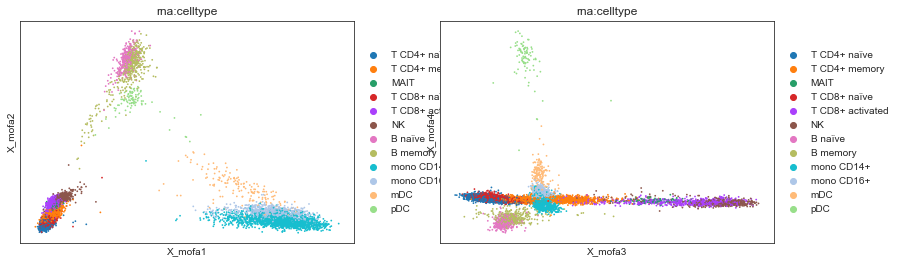

In [10]:
mu.pl.mofa(mdata, color="rna:celltype", components=["1,2", "3,4"])

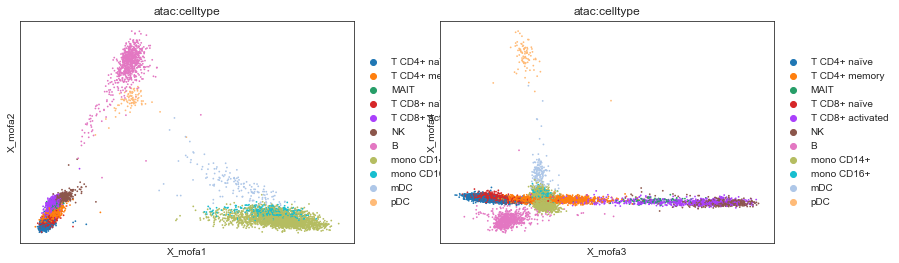

In [11]:
mu.pl.mofa(mdata, color="atac:celltype", components=["1,2", "3,4"])

We can then use this embedding to compare cell type annotation performed individually on each modality and to annotate cell types jointly on both omics.

To visualise all the factors together, we'll use a non-linear dimensionality reduction method such as UMAP to display the embedding in 2D:

In [13]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)

For instance, we can then visualise how cell type annotations performed on individual modalities correspond to this 2D projection of the joint MOFA embeddings:

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'rna:mt' as categorical
... storing 'feature_types' as categorical
... storing 'gene_ids' as categorical
... storing 'interval' as categorical


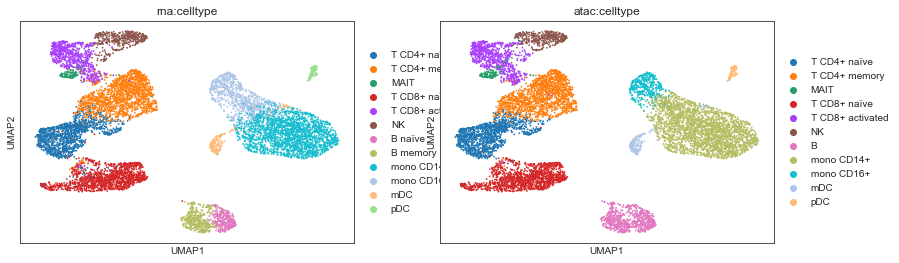

In [14]:
sc.pl.umap(mdata, color=["rna:celltype", "atac:celltype"])
# 'rna:celltype' and 'atac:celltype' are columns in mdata.obs
# derived from 'celltype' columns of invididual modalities

Conventional clustering can now be performed based on the MOFA embeddings and also can be visualised on the same UMAP:

In [15]:
sc.tl.leiden(mdata, resolution=.5)

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


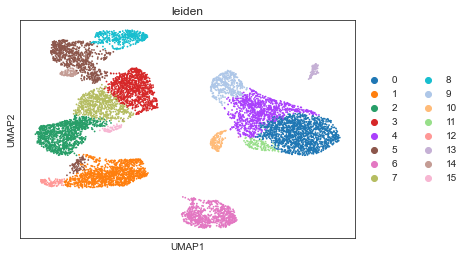

In [16]:
sc.pl.umap(mdata, color="leiden")

Individual features from modalities are also available when plotting embeddings:

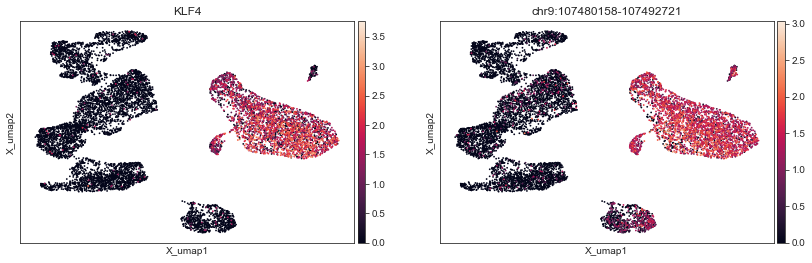

In [17]:
mu.pl.umap(mdata, color=["KLF4", "chr9:107480158-107492721"])

We can also generate custom plots with `matplotlib` and `seaborn`:

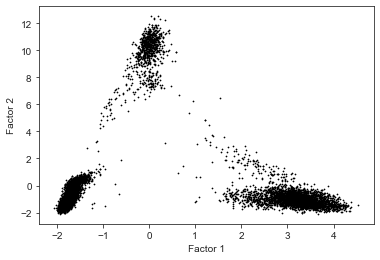

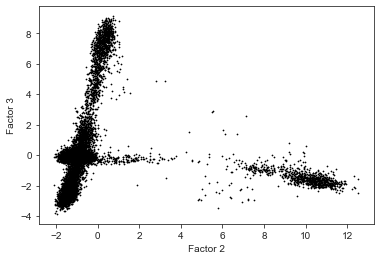

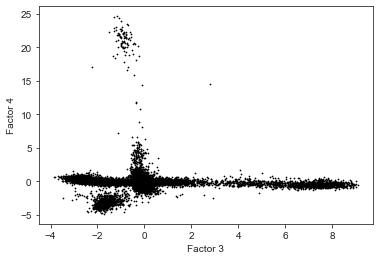

In [18]:
df = pd.DataFrame(mdata.obsm["X_mofa"])
df.columns = [f"Factor {i+1}" for i in range(df.shape[1])]

plot_scatter = lambda i: sns.scatterplot(data=df, x=f"Factor {i+1}", y=f"Factor {i+2}", color="black", linewidth=0, s=3)

for i in range(3):
    plt.figure()
    plot_scatter(i)

# Saving progress on disk

In this notebook we have filtered cells and added MOFA factors & things based on them (neighbourhood graph, clusters, UMAP) to the `mdata` object, and we'll finally save our progress on disk:

In [20]:
mdata.write("data/pbmc10k.h5mu")

/usr/local/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


For a more detailed exploration of the trained MOFA model in Python, please see [this notebook](https://github.com/gtca/multi-omics-tutorials/blob/master/single-cell-rna-atac/pbmc10k/3.1-MOFA-Model-Interpretation.ipynb) that demonstrated how to use [mofa×](https://github.com/gtca/mofax) to interpret the MOFA model that we've trained on the ATAC+RNA multi-omics data.
